In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
# Replace with correct filename if needed
FILENAME = "tradedata.csv"

# Use ISO-8859-1 to avoid UTF-8 decode errors
df = pd.read_csv(FILENAME, encoding='ISO-8859-1')
df.head()


,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
C,A,20240101,2024,52,2024,8,ALB,Albania,X,Export,...,True,0,False,NaN,4.001154e+09,4.001154e+09,4,False,True,NaN
C,A,20240101,2024,52,2024,28,ATG,Antigua and Barbuda,X,Export,...,True,0,False,NaN,3.336187e+07,3.336187e+07,4,False,True,NaN
C,A,20240101,2024,52,2024,31,AZE,Azerbaijan,X,Export,...,False,0,False,NaN,2.655406e+10,2.655406e+10,0,False,True,NaN
C,A,20240101,2024,52,2024,32,ARG,Argentina,X,Export,...,False,0,False,NaN,7.972058e+10,7.972058e+10,0,False,True,NaN
C,A,20240101,2024,52,2024,36,AUS,Australia,X,Export,...,False,0,False,NaN,3.408549e+11,3.408549e+11,0,False,True,NaN


In [3]:
# Convert required fields to string and clean missing values
df['reporterCode'] = df['reporterCode'].astype(str)
df['partnerCode'] = df['partnerCode'].astype(str)
df['motDesc'] = df['motDesc'].astype(str)

# Drop missing and sample subset
# Drop NA and sample up to available rows (max 100)
df_valid = df[['reporterCode', 'partnerCode', 'motDesc', 'cifvalue']].dropna()
sample_size = min(len(df_valid), 100)
df_sample = df_valid.sample(n=sample_size, random_state=42)
df_sample.head()


,reporterCode,partnerCode,motDesc,cifvalue
C,THA,W00,-1,3.007594e+11
C,ALB,W00,-1,4.001154e+09
C,ZWE,W00,-1,7.434439e+09
C,DOM,W00,-1,1.292395e+10
C,BGR,W00,-1,4.664724e+10


In [4]:
G = nx.DiGraph()

for _, row in df_sample.iterrows():
    src = row['reporterCode']
    dst = row['partnerCode']
    mode = row['motDesc']
    
    try:
        value = float(row['cifvalue'])
    except:
        value = 0.0
    
    G.add_edge(
        src,
        dst,
        label=mode,
        weight=value
    )


In [5]:
# Example mapping (extend this as needed)
code_to_name = {
    "USA": "United States",
    "CHN": "China",
    "IND": "India",
    "DEU": "Germany",
    "JPN": "Japan",
    "GBR": "United Kingdom",
    "FRA": "France",
    "BRA": "Brazil",
    "CAN": "Canada",
    "KOR": "South Korea",
    "RUS": "Russia",
    "ITA": "Italy",
    "AUS": "Australia",
    "ESP": "Spain",
    "MEX": "Mexico",
    "IDN": "Indonesia",
    "TUR": "Turkey",
    "SAU": "Saudi Arabia",
    "ZAF": "South Africa",
    "ARG": "Argentina",
    "SWE": "Sweden",
    "NLD": "Netherlands",
    "CHE": "Switzerland",
    "POL": "Poland",
    "THA": "Thailand",
    "EGY": "Egypt",
    "PHL": "Philippines",
    "VNM": "Vietnam",
    "PAK": "Pakistan",
    "IRN": "Iran",
    "UKR": "Ukraine",
    "SGP": "Singapore",
    "NGA": "Nigeria",
    "ISR": "Israel",
    "COL": "Colombia",
    "MYS": "Malaysia",
    "CHL": "Chile",
    "NOR": "Norway",
    "BEL": "Belgium",
    "PER": "Peru",
    "CZE": "Czech Republic",
    "ARE": "United Arab Emirates",
    "AUT": "Austria",
    "GRC": "Greece",
    "IRL": "Ireland",
    "NZL": "New Zealand",
    "KEN": "Kenya",
    "HUN": "Hungary",
    "QAT": "Qatar",
    "KAZ": "Kazakhstan"
}


In [6]:
# Replace node labels with full names
G_named = nx.relabel_nodes(G, lambda x: code_to_name.get(x, x))


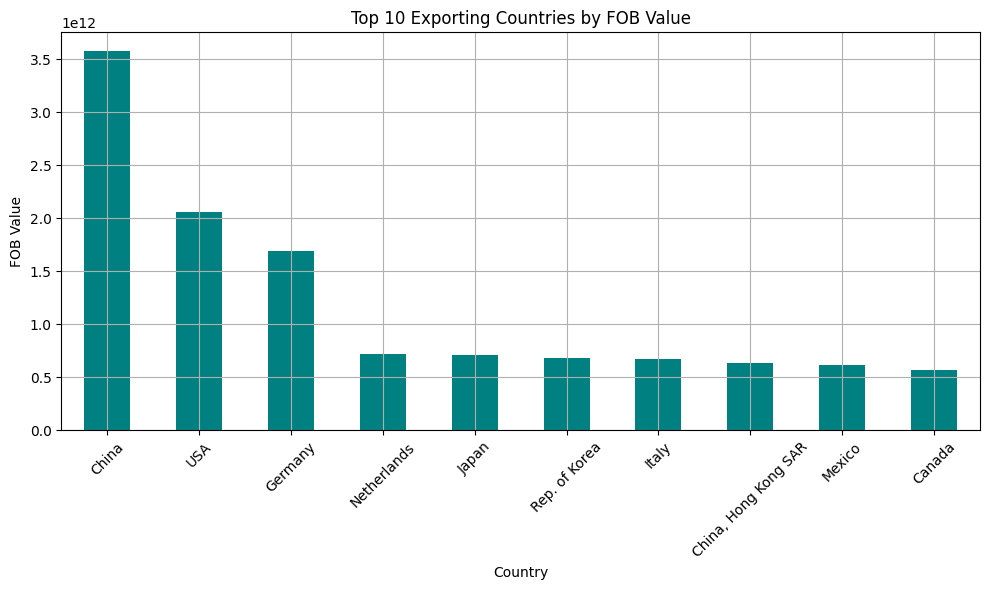

In [7]:
import matplotlib.pyplot as plt

# Aggregate FOB values by reporter (country)
top_exports = df.groupby('reporterISO')['fobvalue'].sum().sort_values(ascending=False).head(10)

# Plot
top_exports.plot(kind='bar', color='teal', figsize=(10, 6))
plt.title('Top 10 Exporting Countries by FOB Value')
plt.ylabel('FOB Value')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


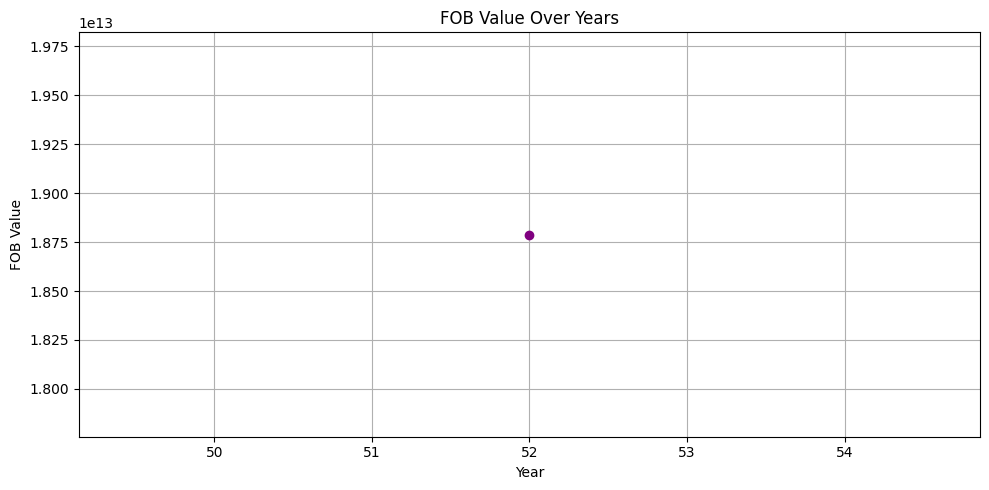

In [8]:
df['refYear'] = pd.to_numeric(df['refYear'], errors='coerce')
df.groupby('refYear')['fobvalue'].sum().plot(kind='line', marker='o', figsize=(10, 5), color='purple')
plt.title("FOB Value Over Years")
plt.ylabel("FOB Value")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


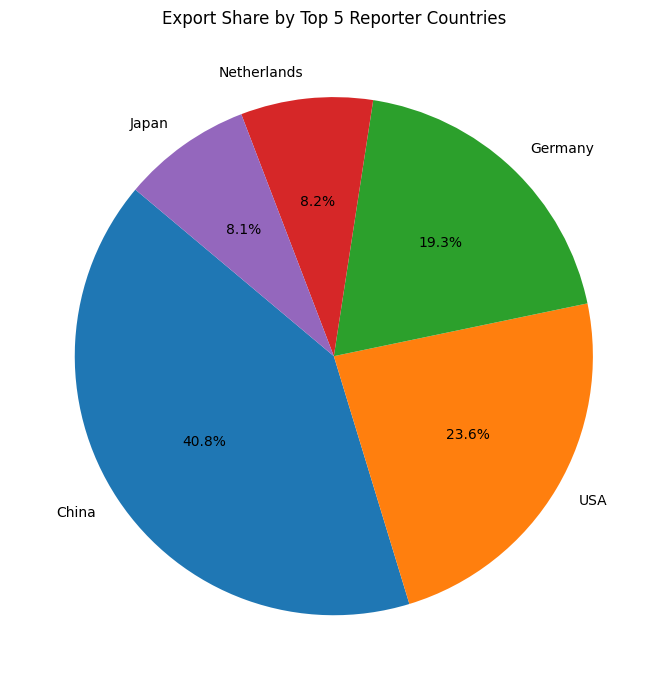

In [9]:
top_regions = df.groupby('reporterISO')['fobvalue'].sum().nlargest(5)
top_regions.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(7, 7))
plt.title('Export Share by Top 5 Reporter Countries')
plt.ylabel('')
plt.tight_layout()
plt.show()


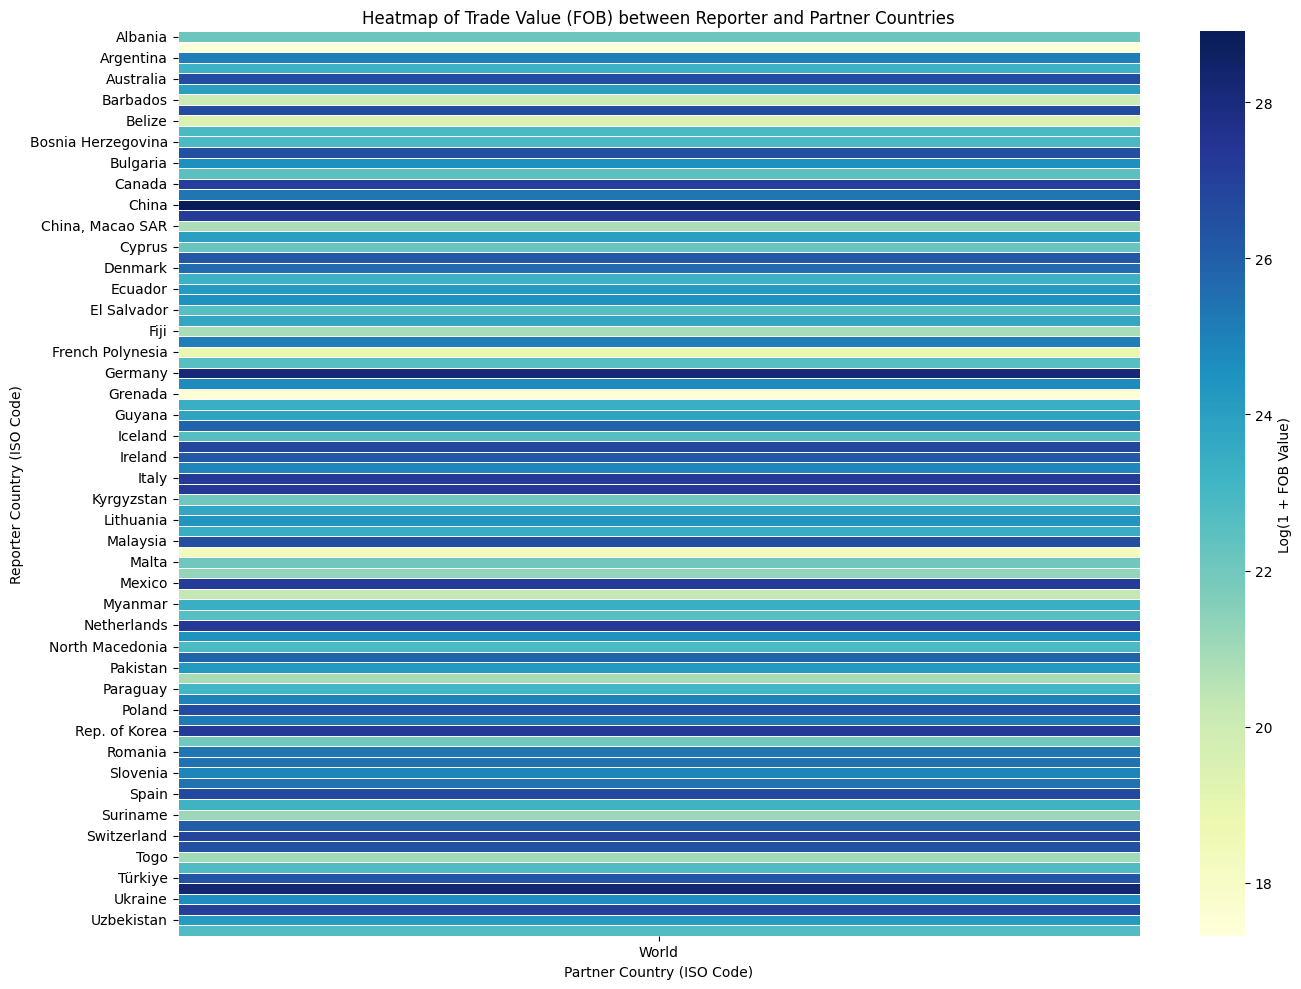

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pivot the data to create matrix for heatmap
heatmap_data = df.pivot_table(
    index='reporterISO',
    columns='partnerISO',
    values='fobvalue',
    aggfunc='sum'
).fillna(0)

# Optional: Sort the index and columns alphabetically for readability
heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

# Optional: Apply log scale if there's a large variance in fobvalue
heatmap_log = np.log1p(heatmap_data)  # log(1 + x) avoids log(0)

# Create the heatmap plot
plt.figure(figsize=(14, 10))
sns.heatmap(
    heatmap_log,
    cmap='YlGnBu',
    linewidths=0.5,
    annot=False,      # Change to True to see numbers
    fmt=".0f",        # Integer format if annot=True
    cbar_kws={'label': 'Log(1 + FOB Value)'}
)

# Labels and title
plt.title('Heatmap of Trade Value (FOB) between Reporter and Partner Countries')
plt.xlabel('Partner Country (ISO Code)')
plt.ylabel('Reporter Country (ISO Code)')
plt.tight_layout()
plt.show()


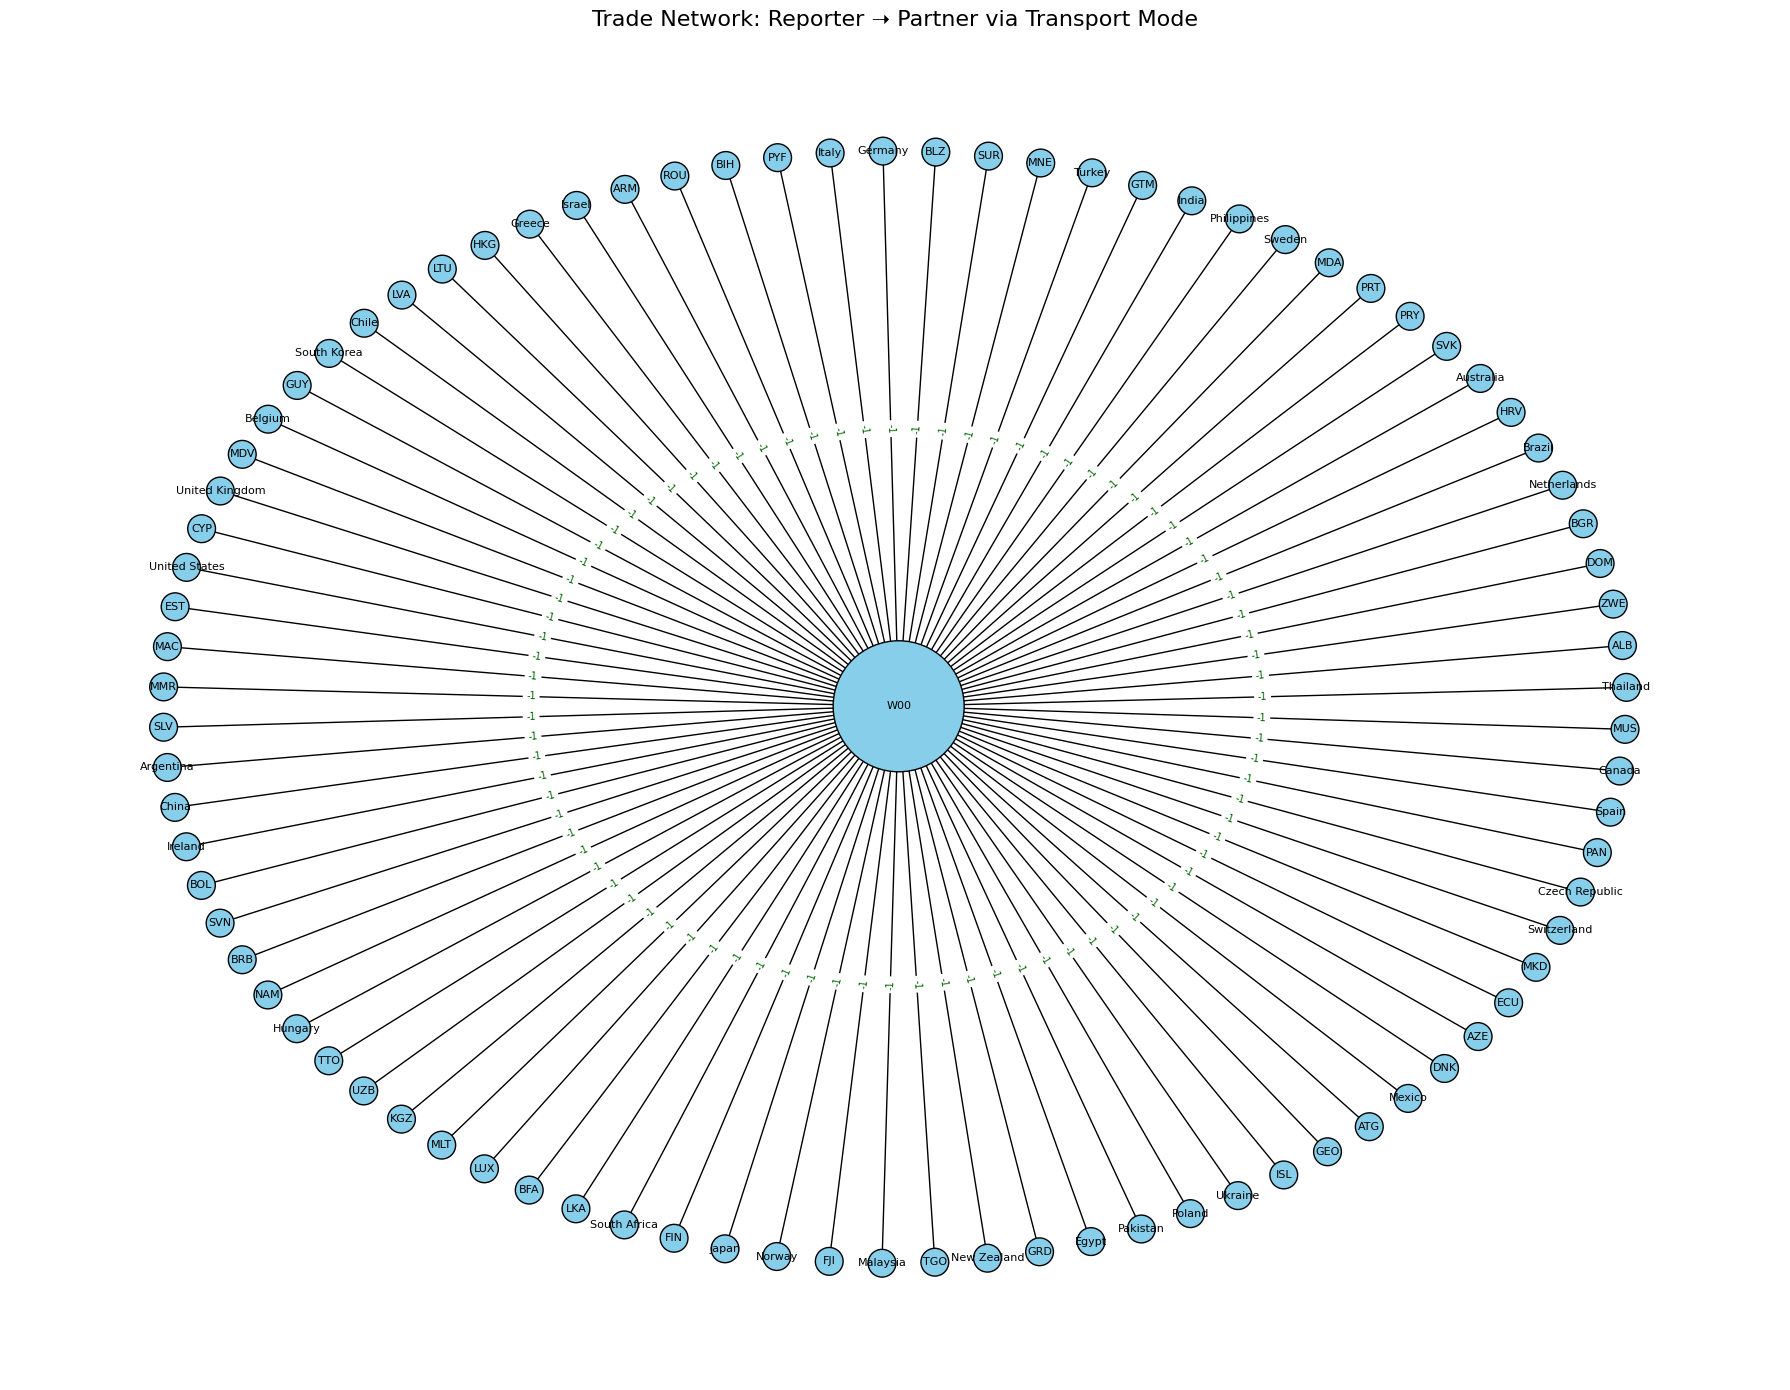

In [ ]:
# Use Kamada-Kawai layout for better spacing
pos = nx.kamada_kawai_layout(G_named)

# Set dynamic node sizes based on degree (optional)
node_sizes = [300 + 100 * G_named.degree(n) for n in G_named.nodes]

# Create figure
plt.figure(figsize=(18, 14))

# Draw nodes
nx.draw_networkx_nodes(G_named, pos, node_size=node_sizes, node_color='skyblue', edgecolors='black')

# Draw labels
nx.draw_networkx_labels(G_named, pos, font_size=8)

# Draw edges
nx.draw_networkx_edges(G_named, pos, arrowstyle='->', arrowsize=15, width=1.0)

# Draw edge labels (truncated transport modes)
edge_labels = {(u, v): d['label'][:15] for u, v, d in G_named.edges(data=True)}
nx.draw_networkx_edge_labels(G_named, pos, edge_labels=edge_labels, font_color='darkgreen', font_size=7)

# Title and layout
plt.title("Trade Network: Reporter ➝ Partner via Transport Mode", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
frequency_df = pd.read_csv('listofFrequency.csv', encoding='ISO-8859-1')

# Reset index to use row names as a column
frequency_df_reset = frequency_df.reset_index().rename(columns={'index': 'Field'})

# Now you can proceed to extract specific columns or create visualizations
api_counts = frequency_df_reset[['Field', 'isInDataAPICommodity', 'isInDataAPIServices', 'isInBulkFileFinal']]


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17112\2442863445.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  api_counts[['isInDataAPICommodity', 'isInDataAPIServices', 'isInBulkFileFinal']] = api_counts[
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17112\2442863445.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  api_counts['Total'] = api_counts.sum(axis=1)


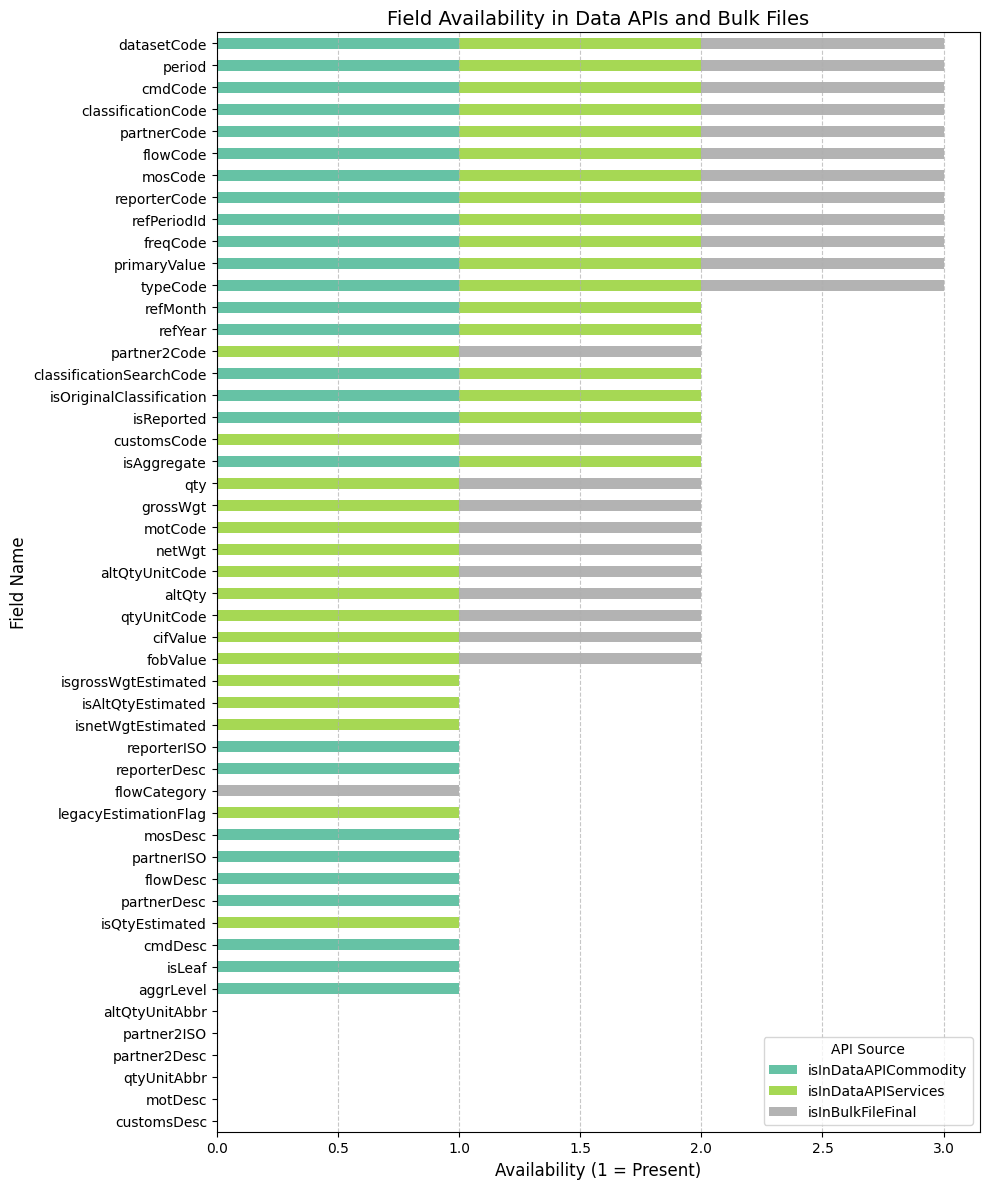

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset (make sure this CSV file is in the working directory)
frequency_df = pd.read_csv('listofFrequency.csv', encoding='ISO-8859-1')

# Reset index to use row names as a column (if index had field names)
frequency_df_reset = frequency_df.reset_index().rename(columns={'index': 'Field'})

# Select relevant columns and convert values to integers (in case they are strings)
api_counts = frequency_df_reset[['Field', 'isInDataAPICommodity', 'isInDataAPIServices', 'isInBulkFileFinal']]
api_counts[['isInDataAPICommodity', 'isInDataAPIServices', 'isInBulkFileFinal']] = api_counts[
    ['isInDataAPICommodity', 'isInDataAPIServices', 'isInBulkFileFinal']
].astype(int)

# Set 'Field' as index
api_counts.set_index('Field', inplace=True)

# Sort fields by total availability (optional for clearer chart)
api_counts['Total'] = api_counts.sum(axis=1)
api_counts_sorted = api_counts.sort_values(by='Total', ascending=True).drop(columns='Total')

# Plot the horizontal stacked bar chart
api_counts_sorted.plot(
    kind='barh',
    figsize=(10, 12),
    stacked=True,
    colormap='Set2'  # You can change this colormap if desired
)

plt.title("Field Availability in Data APIs and Bulk Files", fontsize=14)
plt.xlabel("Availability (1 = Present)", fontsize=12)
plt.ylabel("Field Name", fontsize=12)
plt.legend(title='API Source', loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


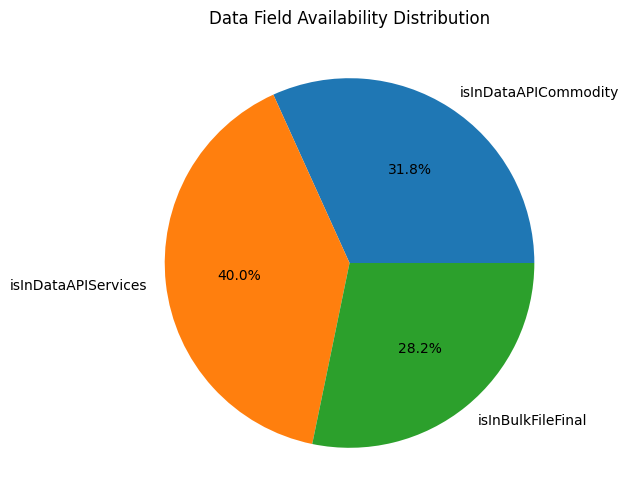

In [ ]:
availability_summary = frequency_df[['isInDataAPICommodity', 'isInDataAPIServices', 'isInBulkFileFinal']].sum()
availability_summary.plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), title="Data Field Availability Distribution")
plt.ylabel('')
plt.show()


In [13]:
# Python
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Java Equivalent (Library Imports):
// import org.apache.commons.csv.*;   // for CSV handling
// import org.jgrapht.*;              // for graph structures
// import org.jfree.chart.*;          // for chart plotting (matplotlib alternative)


SyntaxError: invalid syntax (3070509169.py, line 7)